### 인물모드 직접 해보기
---
- 최소 3장 이상의 인물모드 사진을 만든다.
- 인물 뿐만 아니라 고양이에 대한 아웃포커싱 사진을 만든다.
- 배경 합성을 시도해본다.

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf
    
path = os.getenv('HOME')+'/project/aiffel-lms/e14_portrait/images/'
img_1 = cv2.imread(path+'myimage1.jpg')
img_2 = cv2.imread(path+'myimage2.jpg')
img_3 = cv2.imread(path+'myimage3.jpg')
print(img_1.shape, img_2.shape, img_3.shape)

(720, 960, 3) (961, 720, 3) (3264, 2448, 3)


In [10]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
        
        self.sess = tf.compat.v1.Session(graph=self.graph)
    
    def preprocess(self, img):
        height, width = img.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)
        
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME, 
                                     feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [11]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = 'models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                              download_path)
    
MODEL =DeepLabModel(download_path)
print('model loaded')

temp directory: models
model loaded


In [12]:
img_resized, seg_map = MODEL.run(img_1)
print(img_1.shape, img_resized.shape, seg_map.max())

(720, 960, 3) (384, 513, 3) 15


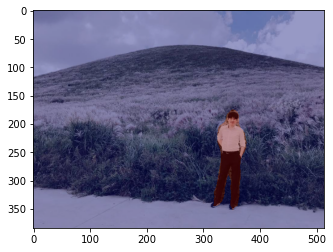

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

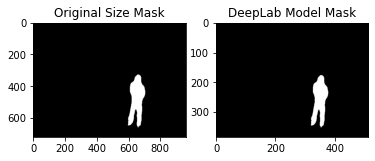

In [20]:
img_mask_up = cv2.resize(img_mask, img_1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

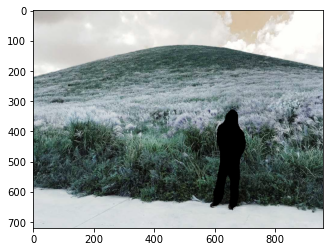

In [21]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_1, img_bg_mask)
plt.imshow(img_bg)
plt.show()

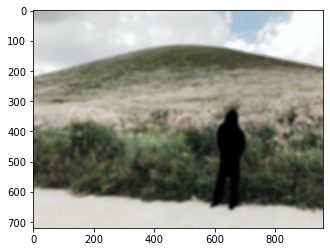

In [22]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

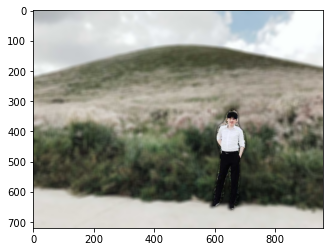

In [25]:
img_concat = np.where(img_mask_color==255, img_1, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

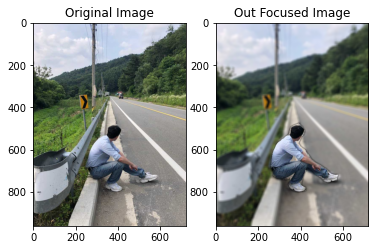

In [31]:
img_resized, seg_map = MODEL.run(img_2)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_2, img_bg_mask)

img_bg_blur = cv2.blur(img_bg, (13,13))

img_concat = np.where(img_mask_color==255, img_2, img_bg_blur)


ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('OutFocused Image')

plt.show()

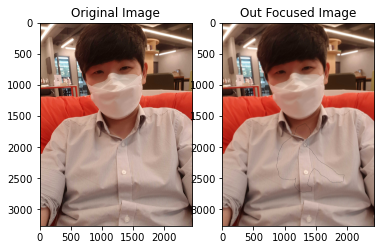

In [32]:
img_resized, seg_map = MODEL.run(img_2)

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

img_mask_up = cv2.resize(img_mask, img_3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_3, img_bg_mask)

img_bg_blur = cv2.blur(img_bg, (13,13))

img_concat = np.where(img_mask_color==255, img_3, img_bg_blur)


ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('OutFocused Image')

plt.show()